In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import time
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')

In [2]:
df = pd.read_csv(r"C:\Users\coolz\assignments\data.csv", names = ['Review', 'Rating'], sep=',', dtype = {"Review": str, 'Rating': 'int32' } )
#df = df.drop_duplicates
df = df.dropna()
np.random.seed(37)
df = df.drop_duplicates(subset=['Review', 'Rating'], keep=False)

Number of rows per rating:
5    107885
4     50787
3     24901
2     16121
1     15511
Name: Rating, dtype: int64


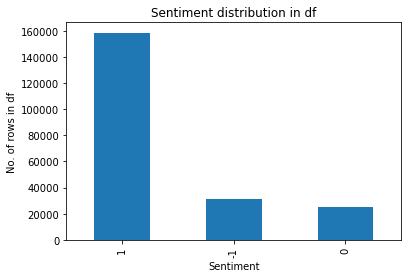

In [3]:
print("Number of rows per rating:")
print(df['Rating'].value_counts())

# Function to map stars to sentiment
def map_sentiment(rating_received):
    if rating_received <= 2:
        return -1
    elif rating_received == 3:
        return 0
    else:
        return 1
# Mapping stars to sentiment into three categories
df['Rating'] = [ map_sentiment(x) for x in df['Rating']]
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(df['Rating']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [4]:
# Function to retrieve top few number of each category
def get_top_data(top_n = 5000):
    top_data_df_positive = df[df['Rating'] == 1].head(top_n)
    top_data_df_negative = df[df['Rating'] == -1].head(top_n)
    top_data_df_neutral = df[df['Rating'] == 0].head(top_n)
    top_data_df_small = pd.concat([top_data_df_positive, top_data_df_negative, top_data_df_neutral])
    return top_data_df_small

# Function call to get the top 10000 from each sentiment
top_data_df_small = get_top_data(top_n=10000)

# After selecting top few samples of each sentiment
print("After segregating and taking equal number of rows for each sentiment:")
print(top_data_df_small['Rating'].value_counts())
top_data_df_small.head(10)

After segregating and taking equal number of rows for each sentiment:
 1    10000
-1    10000
 0    10000
Name: Rating, dtype: int64


,Review,Rating
14,"Мне показалось, что телефон очень прочный, рон...",1
36,"Сразу скажу,что это не отзыв а совет людям,кот...",1
38,Возвращаюсь к Sony после нескольких эксперимен...,1
40,"В целом, за 300 с небольшим баксов вполне вмен...",1
41,После старой Соньки z3 compact хотела только с...,1
54,"мелкие недочеты, если интересно.- Оболочка от ...",1
62,За такие деньги сойдет.,1
64,И впечатления в общем. Асус селфи купила еще в...,1
69,"Телефон очень достойный, мне нравится. Отзыв п...",1
71,"В -20 замерз при разговоре через гарнитуру, по...",1


In [5]:
df = df.applymap(lambda s:s.lower() if type(s) == str else s)
df["no_punkt"] = df['Review'].str.replace('[^\w\s]','')
df['clean'] = df['no_punkt'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


C:\Users\coolz\AppData\Local\Temp/ipykernel_10372/341640829.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["no_punkt"] = df['Review'].str.replace('[^\w\s]','')


In [6]:
def split_train_test(top_data_df_small, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(top_data_df_small[['Review']], 
                                                        top_data_df_small['Rating'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)

Value counts for Train sentiments
 1    7036
-1    7008
 0    6956
Name: Rating, dtype: int64
Value counts for Test sentiments
 0    3044
-1    2992
 1    2964
Name: Rating, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
    index                                             Review
0  138601  Телефон подходит для тех,кому кроме как позвон...
1   52880  Сам по себе телефон неплохой. Большой экран им...
2  142375  Купили телефон на новый год в 2011г через пол ...
3   90816  В общем телефон за эти деньги не плохой. сборк...
4    7852  пересел с iphone 5 на данную модель (думал взя...


In [15]:
size = 1000
window = 3
min_count = 1
workers = 3
sg = 1

word2vec_model_file = r"C:\Users\coolz\assignments" + 'word2vec_' + str(size) + '.model'
start_time = time.time()
stemmed_tokens = pd.Series(top_data_df_small['Review']).values
# Train the Word2Vec Model
w2v_model = Word2Vec(stemmed_tokens, min_count = min_count, vector_size = size, workers = workers, window = window, sg = sg)
print("Time taken to train word2vec model: " + str(time.time() - start_time))
w2v_model.save(word2vec_model_file)

Time taken to train word2vec model: 139.78383350372314


In [24]:
sg_w2v_model = Word2Vec.load(word2vec_model_file)

In [28]:
word2vec_filename = r"C:\Users\coolz\assignments" + 'train_review_word2vec.csv'
with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in X_train.iterrows():
        model_vector = (np.mean([sg_w2v_model.wv[token] for token in row['Review']], axis=0)).tolist()
        if index == 0:
            header = ",".join(str(ele) for ele in range(1000))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(1000)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

In [30]:
word2vec_df = pd.read_csv(word2vec_filename)
#Initialize the model
clf_decision_word2vec = DecisionTreeClassifier()

start_time = time.time()
# Fit the model
clf_decision_word2vec.fit(word2vec_df, Y_train['Rating'])
print("Time taken to fit the model with word2vec vectors: " + str(time.time() - start_time))

Time taken to fit the model with word2vec vectors: 30.968591451644897


In [32]:
test_features_word2vec = []
for index, row in X_test.iterrows():
    model_vector = np.mean([sg_w2v_model.wv[token] for token in row['Review']], axis=0)
    if type(model_vector) is list:
        test_features_word2vec.append(model_vector)
    else:
        test_features_word2vec.append(np.array([0 for i in range(1000)]))
test_predictions_word2vec = clf_decision_word2vec.predict(test_features_word2vec)
print(classification_report(Y_test['Rating'],test_predictions_word2vec))

              precision    recall  f1-score   support

          -1       0.33      1.00      0.50      2992
           0       0.00      0.00      0.00      3044
           1       0.00      0.00      0.00      2964

    accuracy                           0.33      9000
   macro avg       0.11      0.33      0.17      9000
weighted avg       0.11      0.33      0.17      9000



C:\Users\coolz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\coolz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\coolz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
